In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.feature import canny
from skimage.draw import circle_perimeter
from PIL import Image
import cv2 as cv
import os as os

In [2]:
#get image files
path = '/exp/e961/data/30l-13-data/20130613_2/8/'
filesInPath = list(os.walk(path))[0][2]
cam0FileList = []
cam1FileList = []
for file in filesInPath:
    if 'cam0image' in file:
        cam0FileList.append(file)
    elif 'cam1image' in file:
        cam1FileList.append(file)
cam0FileList = np.sort(cam0FileList)
cam1FileList = np.sort(cam1FileList)

In [3]:
def GetGoF(white_x,white_y,center_y,center_x,radius,shape):
    #get pixels in the circles found by the CHT
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=shape)
    #gof = goodness of fit
    gof_sum = 0
    for i in range(len(circy)):
        #find distances between each white pixel and this pixel
        distances = np.sqrt((white_y - circy[i])**2 + (white_x - circx[i])**2)
        gof_sum+=distances.min()**2
    return gof_sum/len(circy)

In [4]:
def GroupBubbles(cxy_ranges,cx,cy,radii):
    bubble_list = []
    for i in range(len(cxy_ranges)):
        in_range = np.where((cx>=cxy_ranges[i][0])&(cx<=cxy_ranges[i][1])&(cy>=cxy_ranges[i][2])&(cy<=cxy_ranges[i][3]))[0]
        if len(in_range)>1:
            selected_rad = np.average(radii[in_range])
            diffs_from_avg = radii[in_range] - selected_rad
            selected_rad_ind = np.where(diffs_from_avg==diffs_from_avg.min())[0][0]
            bubble_list.append(in_range[selected_rad_ind])
        else:
            bubble_list.append(in_range[0])
        bubble_list_unique = np.unique(bubble_list)
    radii = radii[bubble_list_unique]
    cx = cx[bubble_list_unique]
    cy = cy[bubble_list_unique]
    
    return radii, cx, cy

In [8]:
def FindBubbles(camFileList, path, plotMode = False):

    #initialize array of found circle info
    circles_found = np.zeros(((len(camFileList)-1),5,4)) #each circle has 3 params: radius, x center, and y center, plus goodness of fit param
    #currently assumes fewer than 5 bubbles will be found; this can be redone when it's decided how this data should be stored
    
    for i in range(len(camFileList)-1):
        #get two successive images
        im_num = i
        thisImPath = path + camFileList[i]
        nextImPath = path + camFileList[i+1]
        thisIm = np.array(Image.open(thisImPath))
        nextIm = np.array(Image.open(nextImPath))
        
        #get diff, suppress noise and shadows, and make bubbles easier to see and contour
        diff = abs(nextIm - thisIm)
        diff[diff<=25] = 0
        diff[diff>=200] = 0
        diff[diff>0] = 255
        diff = ndimage.gaussian_filter(diff,3) 

        #get contours of image so Hough transform isn't confused by lighter inner ring in larger bubbles
        contour,hier = cv.findContours(diff,cv.RETR_CCOMP,cv.CHAIN_APPROX_SIMPLE)
        rad_cand_max = 0
        for cnt in contour:
            cv.drawContours(diff,[cnt],0,255,-1)
            #find max width of each contour to guess radii
            rad_cand = np.max(cnt,axis=0)[0][0] - np.min(cnt,axis=0)[0][0]
            if rad_cand>rad_cand_max:
                rad_cand_max = rad_cand
        #use Canny edge detection
        edges = canny(diff, sigma=1, low_threshold=10, high_threshold=50) 

        #use width of contours to estimate a good range of radii to iterate over
        if rad_cand_max/2-20<5: 
            min_rad_cand = 3
        else:
            min_rad_cand = rad_cand_max/2-20
        radii_cands = np.unique(np.int32(np.round(np.arange(min_rad_cand,rad_cand_max/2+5,1),1)))

        #execute the actual circular Hough transform (CHT)
        #this is currently the slowest part of the code; in future will try to either optimize or use existing cv2 func
        accum_shape = (edges.shape[0],edges.shape[1],len(radii_cands))
        accum = np.zeros(accum_shape)
        for i in range(np.where(edges==True)[0].shape[0]):
            y = np.where(edges==True)[0][i]
            x = np.where(edges==True)[1][i]
            for k in range(len(radii_cands)):
                circx, circy = circle_perimeter(x, y, radii_cands[k], shape=edges.T.shape)
                accum[circy,circx,k] += 1

        #get center coordinates and radii for most prominent circles found
        circle_thresh = np.max(accum)/3
        cy = np.where(accum>=circle_thresh)[0]
        cx = np.where(accum>=circle_thresh)[1]
        radii = radii_cands[np.where(accum>=circle_thresh)[2]]
        #just a bandaid for now so it doesn't hang on the bubble grouping step when there's no bubble
        if len(radii)>500:
            print("No bubbles found")
            if plotMode==True:
                plt.imshow(nextIm,cmap='gray')
                plt.show()
            continue

        #where multiple circles overlap within a square of side length 4r, 
        #choose one with radius closest to average of overlapping circle radii
        cxy_ranges = [[cx[i]-2*radii[i], cx[i]+2*radii[i], cy[i]-2*radii[i], cy[i]+2*radii[i]] for i in range(len(cx))]
        radii, cx, cy = GroupBubbles(cxy_ranges,cx,cy,radii)
        
        #get goodness of fit parameter and build ouput
        #the output will have to be revisited when we decide what we want it to look like/ what would be easiest for analysis
        white_y = np.where(edges.astype(np.uint8)==1)[0]
        white_x = np.where(edges.astype(np.uint8)==1)[1]
        gofs = []
        for j in range(len(radii)):
            gof = GetGoF(white_x,white_y,cy[j],cx[j],radii[j],thisIm.shape)
            circles_found[im_num][j][0] = radii[j]
            circles_found[im_num][j][1] = cx[j]
            circles_found[im_num][j][2] = cy[j]
            circles_found[im_num][j][3] = gof
            gofs.append(gof)

        #plot, if desired, to see if this method is working well
        if plotMode==True:
            print(len(radii),'bubbles found')
            print('Bubble radii:',radii)
            print('Goodness of fit params:',gofs)
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))

            #draw circle on image
            for center_y, center_x, radius in zip(cy, cx, radii):
                circy, circx = circle_perimeter(np.int32(center_y), np.int32(center_x), np.int32(radius), shape=nextIm.shape)
                nextIm[circy,circx] = 255 
                #edges[circy,circx] = 255 
                
            ax.imshow(nextIm,cmap='gray')
            #ax.imshow(edges,cmap='gray')
            ax.scatter(cx,cy,s=1,c='r',alpha=0.5) #adding red dots on top of circles too small to see easily
            plt.show()
            
    return circles_found

No bubbles found


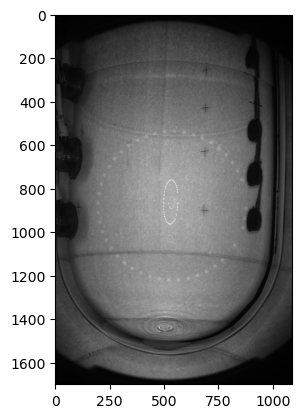

No bubbles found


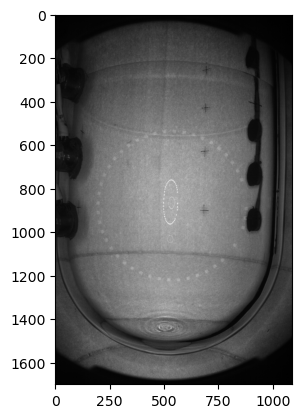

No bubbles found


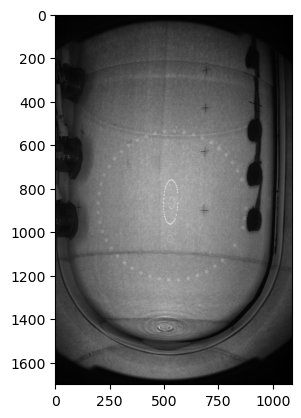

1 bubbles found
Bubble radii: [6]
Goodness of fit params: [np.float64(9.15)]


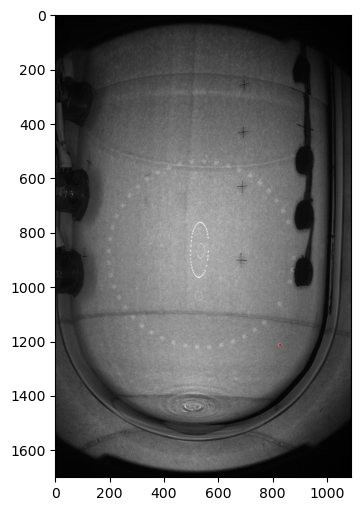

2 bubbles found
Bubble radii: [5 9]
Goodness of fit params: [np.float64(0.0), np.float64(24.357142857142858)]


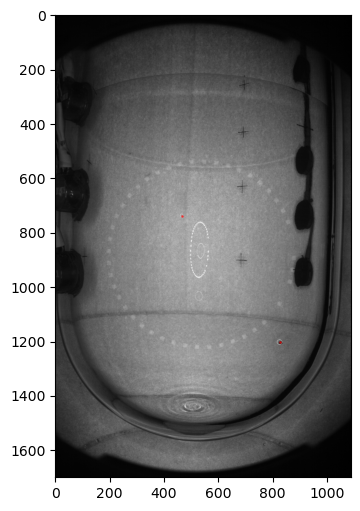

1 bubbles found
Bubble radii: [14]
Goodness of fit params: [np.float64(14.079545454545455)]


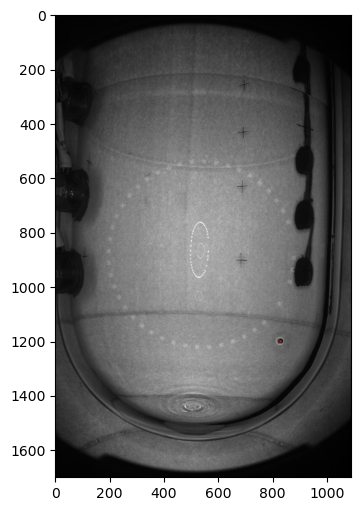

1 bubbles found
Bubble radii: [17]
Goodness of fit params: [np.float64(21.64423076923077)]


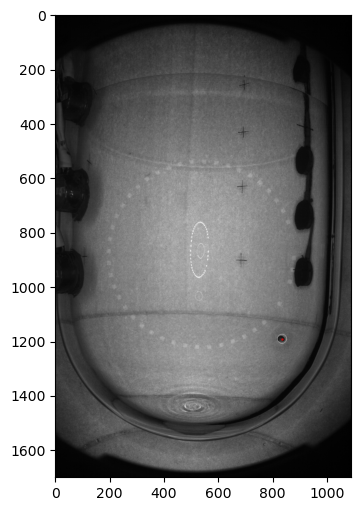

1 bubbles found
Bubble radii: [16]
Goodness of fit params: [np.float64(85.05208333333333)]


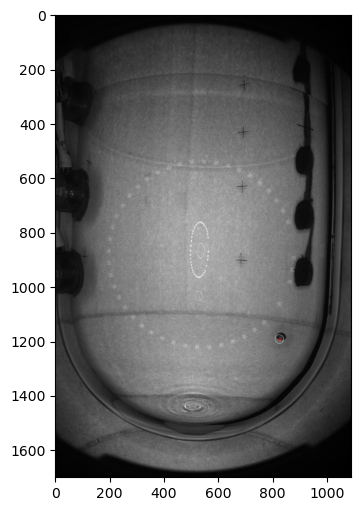

1 bubbles found
Bubble radii: [15]
Goodness of fit params: [np.float64(153.2840909090909)]


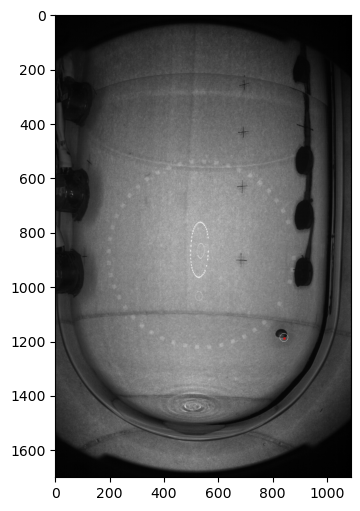

In [6]:
circles_found = FindBubbles(cam0FileList,path,True)

In [7]:
#index by index, we have
#image number
#bubble number (right now up to 5)
#0 = r, 1 = center x coord, 2 = center y coord, 3 = goodness of fit
circles_found[4][:3]

array([[   5.        ,  465.        ,  737.        ,    0.        ],
       [   9.        ,  825.        , 1203.        ,   24.35714286],
       [   0.        ,    0.        ,    0.        ,    0.        ]])